# Imports and parameters

In [1]:
import pandas as pd
import numpy as np

import lib.draw as draw
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.neural_network import MLPClassifier
import optuna
from sklearn.metrics import mean_squared_error
import pickle

from tqdm import tqdm
from glob import glob

In [2]:
# Ajust to create denser maps
DENSITY_X, DENSITY_Y = 1, 1.5
ENABLE_OPTIMIZATION = False

# Load data

In [3]:
df = pd.read_csv('data/formated_data.csv').drop('Unnamed: 0', axis = 1)

In [4]:
df = df[df.type.isin(['Pass', 'OffsidePass', 'CrossNotClaimed'])].dropna()
df

type  player  team  success      x      y   endX   endY  isShot  \
0       Pass  322852  2187        1  0.501  0.519  0.373  0.572   False   
1       Pass   83556  2187        1  0.372  0.573  0.319  0.790   False   
2       Pass  137387  2187        1  0.333  0.766  0.243  0.597   False   
3       Pass  322847  2187        1  0.253  0.678  0.280  0.321   False   
4       Pass  322849  2187        0  0.365  0.114  0.886  0.000   False   
...      ...     ...   ...      ...    ...    ...    ...    ...     ...   
243770  Pass   90310   297        1  0.686  0.210  0.663  0.374   False   
243771  Pass   94891   297        1  0.652  0.458  0.680  0.875   False   
243772  Pass  125793   297        0  0.692  0.947  0.961  0.555   False   
243773  Pass   32381   108        0  0.150  0.484  0.727  0.603   False   
243774  Pass  291653   108        1  0.622  0.400  0.680  0.581   False   

        isGoal  ...  xdribble  ydribble  toFoul  toCorner         r         a  \
0        False  ...     0.501     0.519   False     False  0.138539  0.937521   
1        False  ...     0.372     0.573   False     False  0.223379  0.788126   
2        False  ...     0.333     0.766   False     False  0.191471  0.172119   
3        False  ...     0.253     0.678   False     False  0.358020  0.262014   
4        False  ...     0.365     0.114   False     False  0.533326  0.465716   
...        ...  ...       ...       ...     ...       ...       ...       ...   
243770   False  ...     0.686     0.210   False     False  0.165605  0.772176   
243771   False  ...     0.652     0.458   False     False  0.417939  0.739329   
243772   False  ...     0.692     0.947   False     False  0.475421  0.345719   
243773   False  ...     0.150     0.484   False     False  0.589143  0.532370   
243774   False  ...     0.622     0.400   False     False  0.190066  0.700645   

        rebound_r  rebound_a  dribble_r  dribble_a  
0        0.000000   0.500000        0.0        0.5  
1        0.000000   0.500000        0.0        0.5  
2        0.000000   0.500000        0.0        0.5  
3        0.000000   0.500000        0.0        0.5  
4        0.000000   0.500000        0.0        0.5  
...           ...        ...        ...        ...  
243770   0.000000   0.500000        0.0        0.5  
243771   0.000000   0.500000        0.0        0.5  
243772   0.611485   0.144929        0.0        0.5  
243773   0.479416   0.471969        0.0        0.5  
243774   0.000000   0.500000        0.0        0.5  

[229060 rows x 33 columns]

In [5]:
df[['x','y','r','a','success']]

x      y         r         a  success
0       0.501  0.519  0.138539  0.937521        1
1       0.372  0.573  0.223379  0.788126        1
2       0.333  0.766  0.191471  0.172119        1
3       0.253  0.678  0.358020  0.262014        1
4       0.365  0.114  0.533326  0.465716        0
...       ...    ...       ...       ...      ...
243770  0.686  0.210  0.165605  0.772176        1
243771  0.652  0.458  0.417939  0.739329        1
243772  0.692  0.947  0.475421  0.345719        0
243773  0.150  0.484  0.589143  0.532370        0
243774  0.622  0.400  0.190066  0.700645        1

[229060 rows x 5 columns]

# Gradient functions

In [6]:
# Function to visualize the gradient
def plot_xpmap(xpmap, fromX, fromY):
    draw.pitch()
    
    xpmap.x *= 100
    xpmap.y *= 100
    xpmap.endX *= 100
    xpmap.endY *= 100

    cmap = np.zeros((len(xpmap),4))
    ar_xpmap = xpmap.xp
    cmap[:,0] = 1; cmap[:,1] = 1; cmap[:,2] = 1; cmap[:,3] = ar_xpmap
    plt.scatter(xpmap.endX, xpmap.endY, s = 15, c = cmap, marker = 's', linewidth=0, zorder = 10);
    plt.scatter(fromX, fromY, s = 15, c = 'purple', marker = 's', linewidth=0, zorder = 11)

In [7]:
# Handler to create the dataframe and calculate xpmap
def calculate_xpmap(clf, fromX, fromY):
    xpmap = [[fromX/100, fromY/100, i/100, j/100] for i in range(0, 100, DENSITY_X) for j in np.arange(0, 100, DENSITY_Y)]
    xpmap = pd.DataFrame(xpmap, columns=['x','y', 'endX', 'endY'])
    xpmap['r'] = np.sqrt((xpmap.endX - xpmap.x) ** 2 + (xpmap.endY - xpmap.y) ** 2)
    xpmap['a'] = np.arctan2(xpmap.endY - xpmap.y, xpmap.endX - xpmap.x) / (2 * np.pi) + 0.5
    xpmap['xp'] = clf.predict_proba(xpmap[['x','y', 'r', 'a']])[:,1]

    return xpmap

# Check best fitted model using Bayesian Optimization

In [8]:
# Sample data to run faster
sample_df = df.sample(20000)

In [9]:
# Optimization function
def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int('n_units_l{}'.format(i), 4, 128))

    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    lr = trial.suggest_float('learning_rate', 0.001, 0.05)
    lr_type = trial.suggest_categorical('learning_rate_type', ['constant', 'invscaling', 'adaptive'])
    max_iterations = trial.suggest_int('epochs', 20, 750)
    early_stop = trial.suggest_categorical('early_stop', [False, True])
    
    clf = MLPClassifier(hidden_layer_sizes=layers, activation=activation, learning_rate_init=lr, learning_rate=lr_type, max_iter=max_iterations, early_stopping=early_stop)
    clf.fit(sample_df[['x', 'y', 'r', 'a']], sample_df['success'])

    pred = clf.predict_proba(sample_df[['x', 'y', 'r', 'a']])[:,1]

    return mean_squared_error(pred, sample_df['success'])

In [10]:
# Run Bayesian Optimization Study
if ENABLE_OPTIMIZATION:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    print(study.best_params)

# Train model

In [11]:
#clf = MLPClassifier(hidden_layer_sizes=[94, 110, 13, 9, 82], activation='relu', learning_rate_init=0.003157768753161701, learning_rate='adaptive', max_iter=346)
clf = MLPClassifier(hidden_layer_sizes=[8, 86, 32, 128, 126], activation='tanh', learning_rate_init=0.0011742437070288558, learning_rate='invscaling', max_iter=352)
clf.fit(df[['x', 'y', 'r', 'a']], df['success'])

MLPClassifier(activation='tanh', hidden_layer_sizes=[8, 86, 32, 128, 126],
              learning_rate='invscaling',
              learning_rate_init=0.0011742437070288558, max_iter=352)

# Save model

In [12]:
pickle.dump(clf, open('matrix/pass_gradient.sav', 'wb'))

# Plot Visualizations

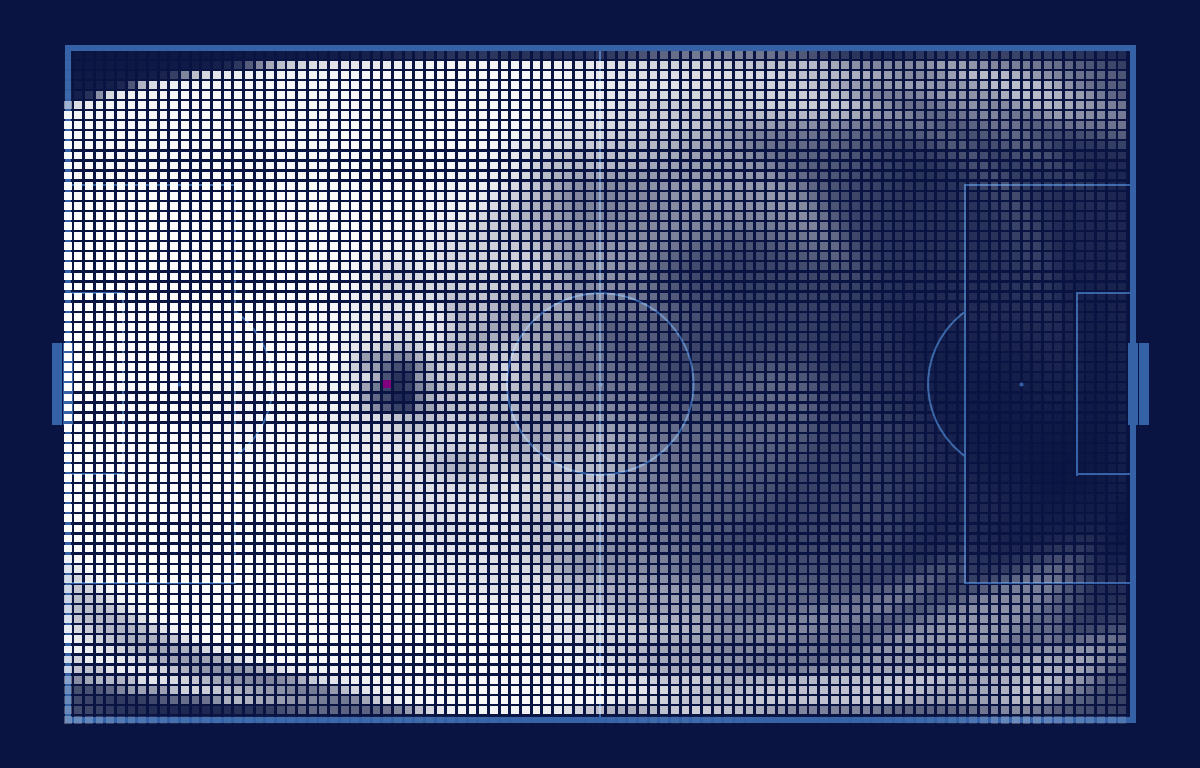

In [13]:
fromX, fromY = 30, 50
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

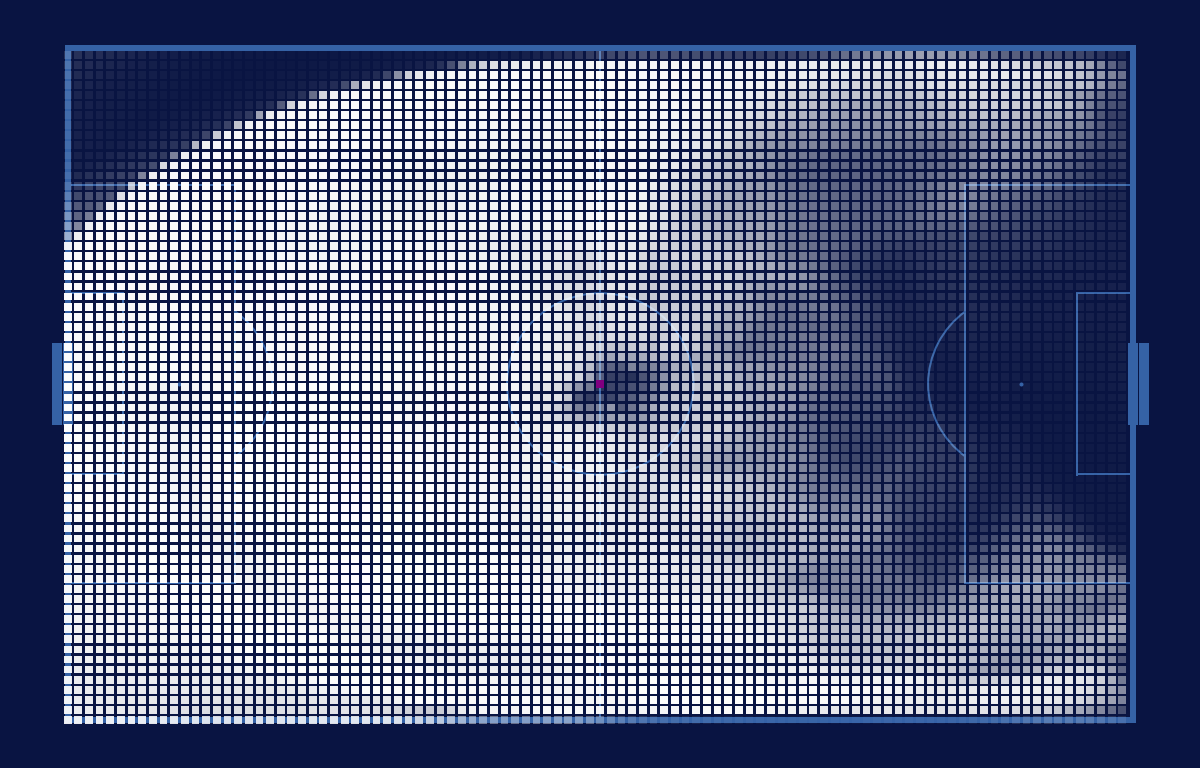

In [14]:
fromX, fromY = 50, 50
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

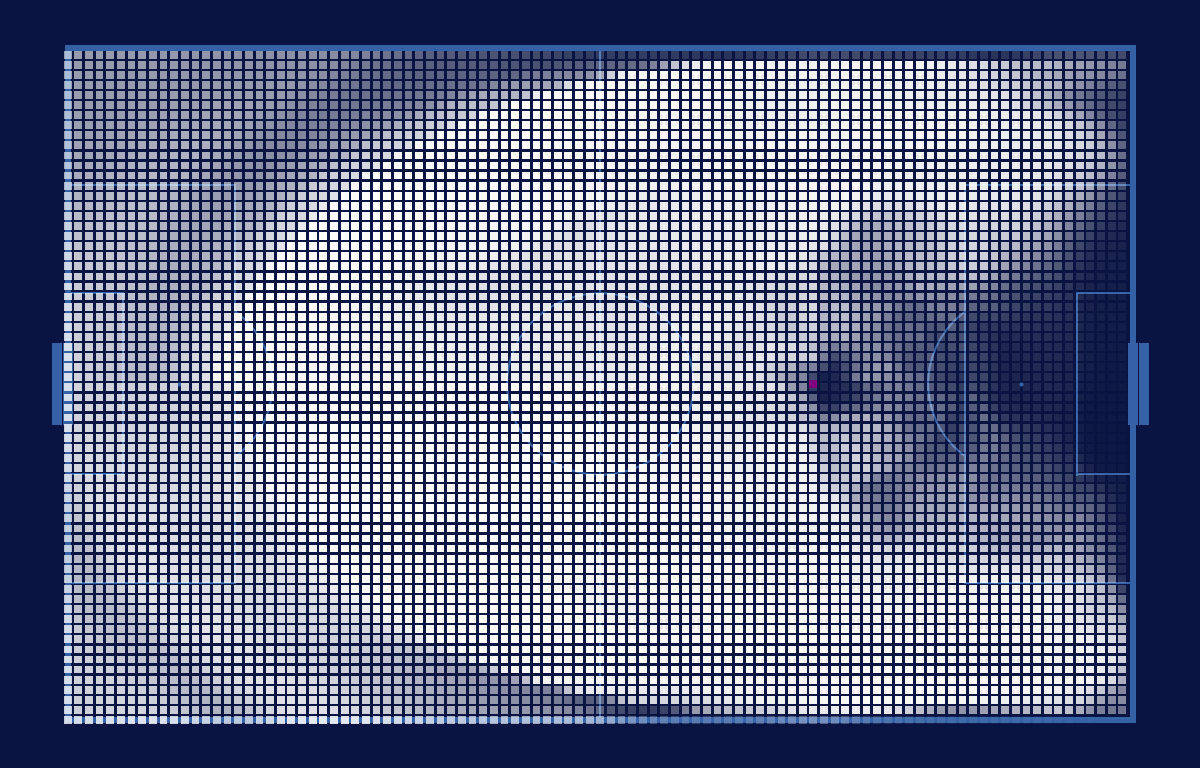

In [15]:
fromX, fromY = 70, 50
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

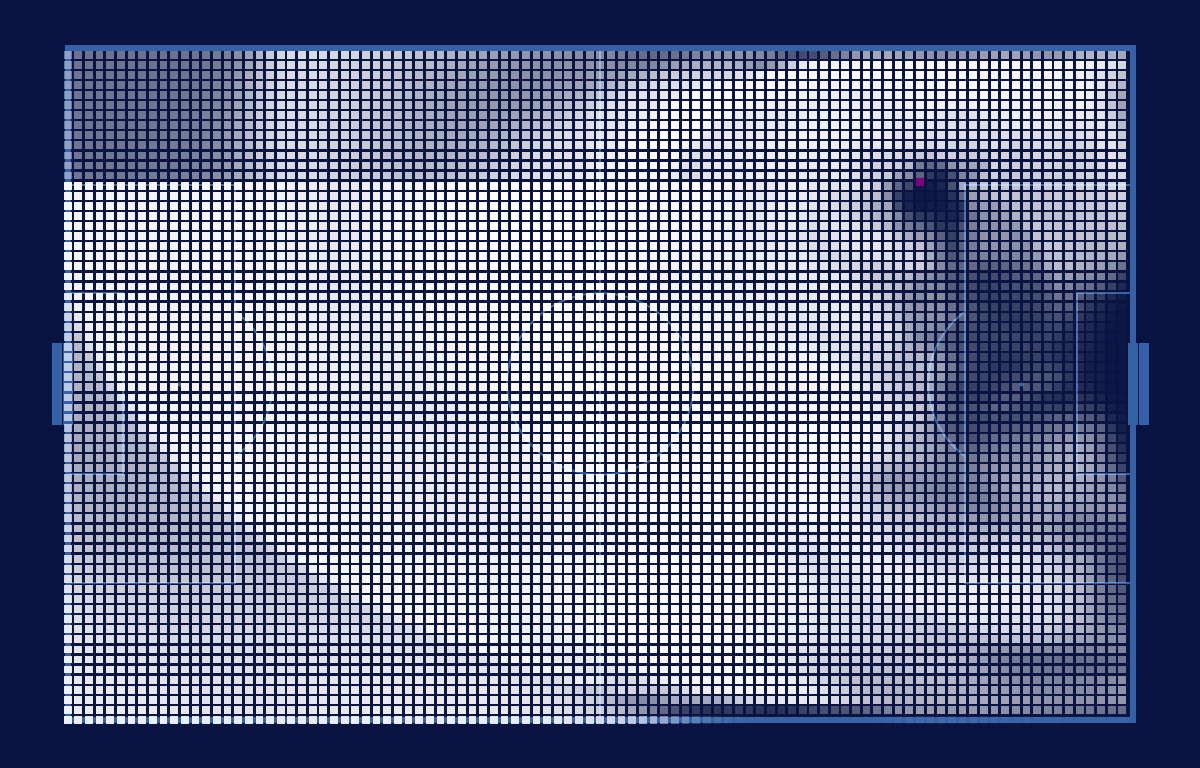

In [16]:
fromX, fromY = 80, 80
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

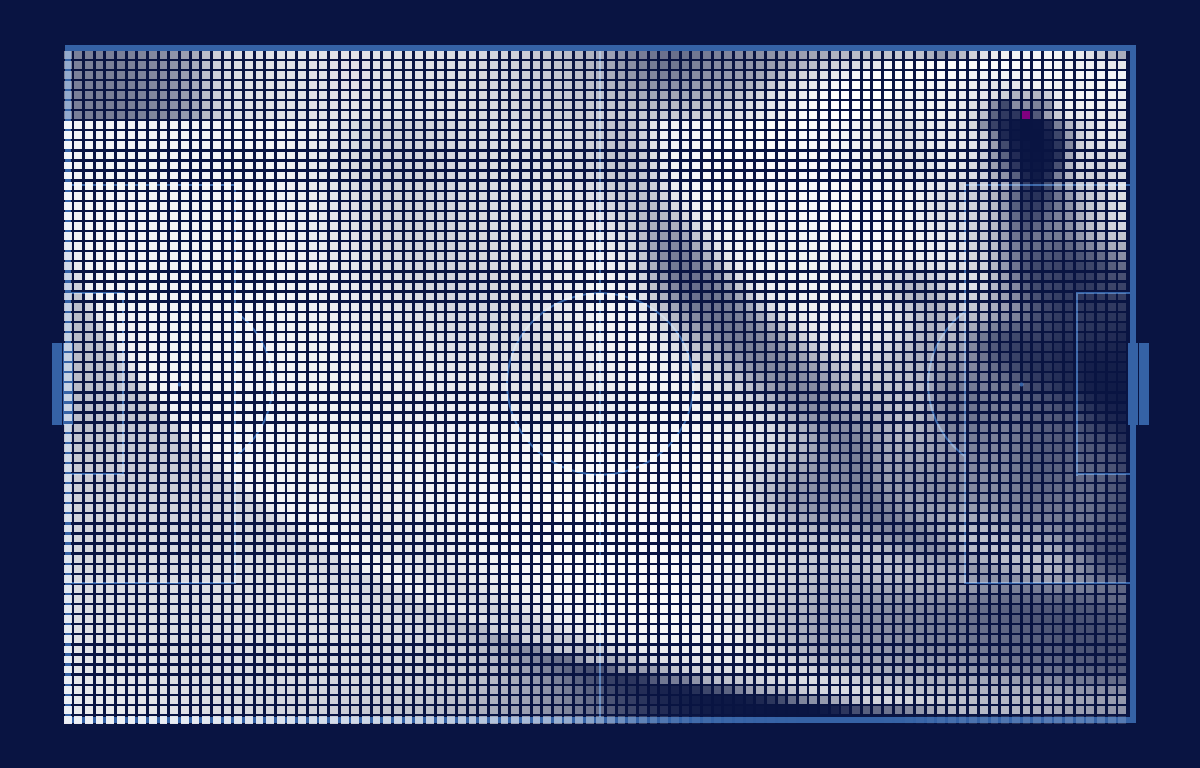

In [17]:
fromX, fromY = 90, 90
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)

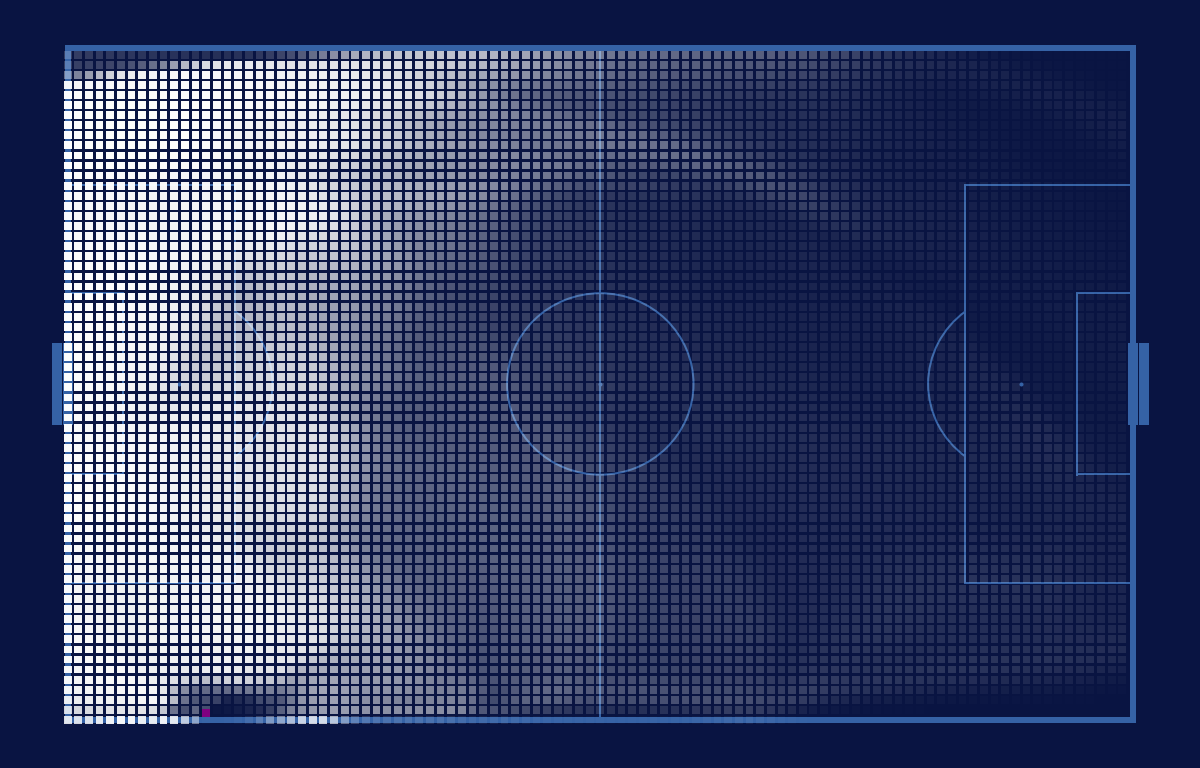

In [18]:
fromX, fromY = 13, 1
xpmap = calculate_xpmap(clf, fromX, fromY)
plot_xpmap(xpmap, fromX, fromY)